In [1]:
import matplotlib.pyplot as plt
import datetime
import os
import json
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import numpy as np
from main_pygod import get_data_from_loader, load_dataset, make_loader, create_model, train_model, test_model
import warnings

%load_ext autoreload
%autoreload 2

In [2]:
def create_metrics():
    return {"overall": {"roc_auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []},
            "licit": {"precision": [], "recall": [],"f1-score": []}, 
           "illicit":{"precision": [], "recall": [],"f1-score": []}}

def hyperparameter_loop(group_para, parameter, parameter_list, metrics):
    """
    Run a grid search for a hyperparameter
    Args: hyperparameter, hyperparameter list, classification metrics (empty dict)
    Returns: Classification metrics dictionary
    """ 
    warnings.filterwarnings('ignore')
    for i in range(len(parameter_list)):
        config[group_para][parameter] = parameter_list[i]
        timestamp = config["model"]["backbone"]+"_hid_dim"+str(config["model"]["hid_dim"])+"_num_l"+str(config["model"]["num_layers"])
        timestamp += "_dropout"+str(config["model"]["dropout"])+ "_epoch"+str(config["model"]["epoch"])
        dataset, input_nodes = load_dataset(mask="train",use_aggregated=config["data"]["use_aggregated"],use_temporal=config["data"]["use_temporal"])
        loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes)
        train_data = get_data_from_loader(loader)

        mymodel = create_model(config=config["model"])

        trained_model = train_model(mymodel, train_data, output_directory=config["training"]["save_dir"], save_embeddings=config["training"]["save_embeddings"], timestamp=timestamp)
    
        dataset, input_nodes = load_dataset(mask="test",use_aggregated=config["data"]["use_aggregated"], use_temporal=config["data"]["use_temporal"])
        loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes,)    
        test_data = get_data_from_loader(loader)

        test_metrics = test_model(model=trained_model, data=test_data, output_directory=config["training"]["save_dir"], timestamp=timestamp)

        for key in list(test_metrics.keys())[0:-1]:
            metrics["overall"][key].append(test_metrics[key])
        output = test_metrics["classification_report"]
        for key in list(output["0"].keys())[0:-1]:
            metrics["licit"][key].append(output["0"][key])
            metrics["illicit"][key].append(output["1"][key])
    
    return metrics


def plot_metrics(metrics, para_list, parameter, x_log = False):
    """
    Plot the classification metrics
    Args:classification metrics
    Returns:None
    """ 

    size = (8,3)
    plt.figure(figsize= size)
    for key in list(metrics["overall"]):
        plt.plot(para_list, metrics["overall"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Total Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Overall Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["licit"]):
        plt.plot(para_list, metrics["licit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Licit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Licit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["illicit"]):
        plt.plot(para_list, metrics["illicit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Illicit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Illicit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

## Base DOMINANT

In [3]:
config = {
        "model": {
            "hid_dim": 128,
            "num_layers": 4,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            "backbone": "gcn_skip",
            "lr": 0.005,
            "epoch": 10,
            "batch_size": 2048,
            "num_neigh": 10,
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "use_aggregated": True,
            "use_temporal": False,
            "batch_size": 16000
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
    }

#### Number of layers

In [4]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [2, 3, 4, 5, 6,7]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[30414, 165], edge_index=[2, 28934], y=[30414])
creating model with {'hid_dim': 128, 'num_layers': 2, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x1698d8700>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 10, 'gpu': -1, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 1035.1979 | 
Epoch 0001: Loss 108.0603 | 
Epoch 0002: Loss 67.4836 | 
Epoch 0003: Loss 55.3423 | 
Epoch 0004: Loss 49.4731 | 
Epoch 0005: Loss 47.8413 | 
Epoch 0006: Loss 43.6766 | 
Epoch 0007: Loss 40.8737 | 
Epoch 0008: Loss 38.7552 | 
Epoch 0009: Loss 36.0666 | 
model training complete!
data loaded from loader:
Data(x=[24944, 165], edge_index=[2, 22807], y=[24944])
testing model...
Test: Loss 0.3684 | 
ROC AUC: 0.4830
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.43      0.59     15016


In [5]:
metrics

{'overall': {'roc_auc': [0.4829864892882731,
   0.4917642752562226,
   0.49653025291867814,
   0.4979736088956481,
   0.4930331329985971,
   0.51856882834178],
  'accuracy': [0.44183145156259745,
   0.36949744357151765,
   0.3473730188443779,
   0.33262619329880827,
   0.4282327989520304,
   0.3526328924382331],
  'f1': [0.11441013460015835,
   0.1090748898678414,
   0.1055332250064141,
   0.10478741211918313,
   0.11371108102881454,
   0.12453594330070875],
  'precision': [0.06359335460446694,
   0.05987618494873283,
   0.05777153558052434,
   0.057236902258388955,
   0.06302250803858521,
   0.06808746194298367],
  'recall': [0.5694581280788177,
   0.6116600790513834,
   0.6090819348469891,
   0.619188921859545,
   0.5810276679841897,
   0.7285291214215203]},
 'licit': {'precision': [0.9370498415442235,
   0.9310526315789474,
   0.9259259259259259,
   0.9243614931237721,
   0.93672586181167,
   0.94700327616111],
  'recall': [0.43320458177943527,
   0.3531878077998137,
   0.3297142476

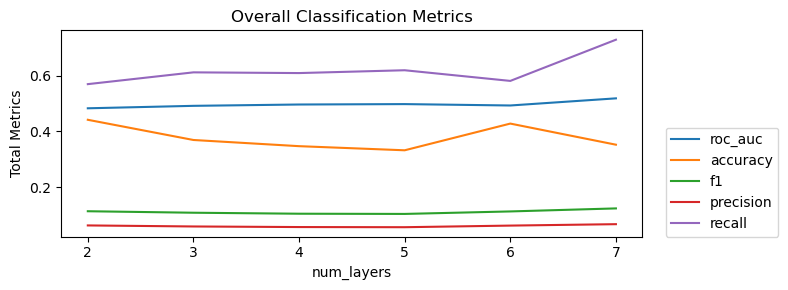

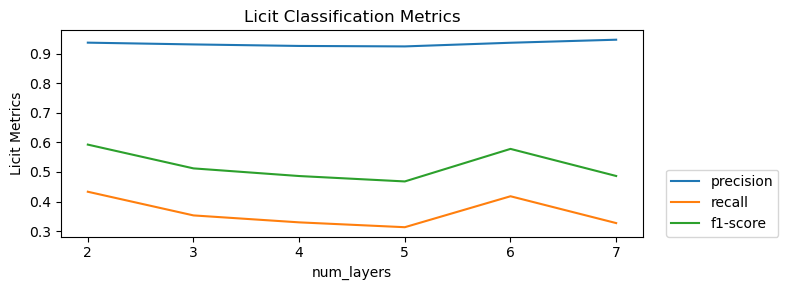

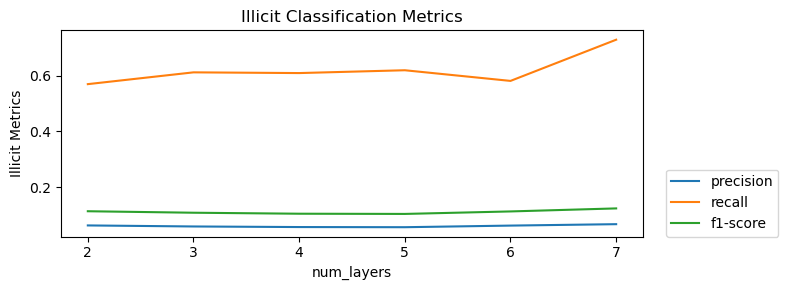

In [6]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [7]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [64, 128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[30477, 165], edge_index=[2, 28968], y=[30477])
creating model with {'hid_dim': 64, 'num_layers': 7, 'dropout': 0.2, 'weight_decay': 0.0, 'act': <function relu at 0x1698d8700>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 10, 'gpu': -1, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 620.4792 | 
Epoch 0001: Loss 103.1667 | 
Epoch 0002: Loss 59.5095 | 
Epoch 0003: Loss 45.2186 | 
Epoch 0004: Loss 36.9497 | 
Epoch 0005: Loss 33.9159 | 
Epoch 0006: Loss 28.8346 | 
Epoch 0007: Loss 27.7483 | 
Epoch 0008: Loss 26.4261 | 
Epoch 0009: Loss 24.4404 | 
model training complete!
data loaded from loader:
Data(x=[24901, 165], edge_index=[2, 22808], y=[24901])
testing model...
Test: Loss 0.1541 | 
ROC AUC: 0.4801
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79     15016
  

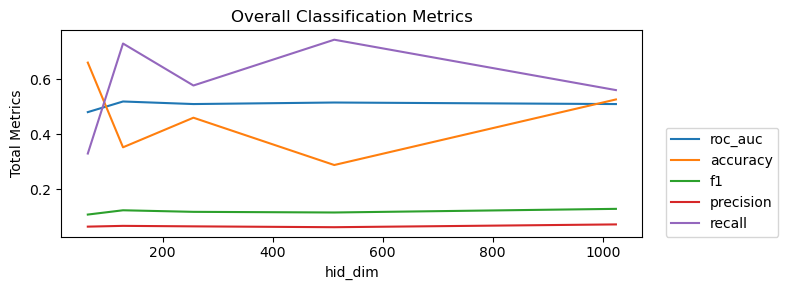

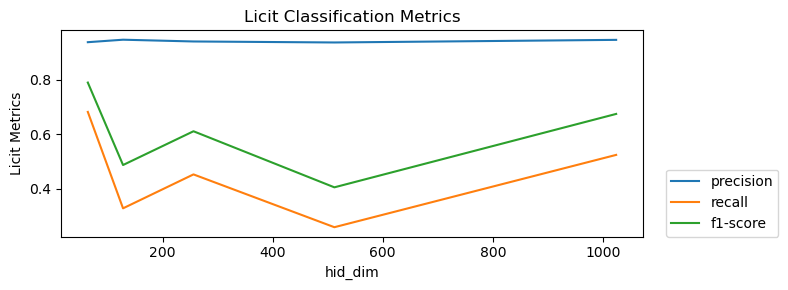

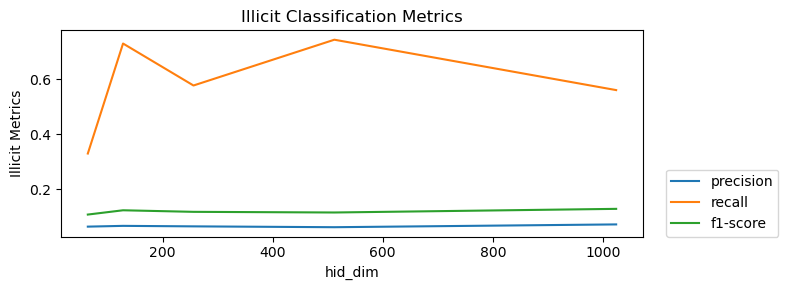

In [8]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [9]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.0, 0.1, 0.2, 0.3]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[30477, 165], edge_index=[2, 28968], y=[30477])
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.0, 'weight_decay': 0.0, 'act': <function relu at 0x1698d8700>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 10, 'gpu': -1, 'batch_size': 2048, 'num_neigh': 10, 'weight': 0.5, 'verbose': 1, 'backbone': <class 'src.backbone.GCNSkipBackbone'>}
training model...
Epoch 0000: Loss 14193.9292 | 
Epoch 0001: Loss 2336.2407 | 
Epoch 0002: Loss 1272.1162 | 
Epoch 0003: Loss 713.5028 | 
Epoch 0004: Loss 426.1288 | 
Epoch 0005: Loss 285.7068 | 
Epoch 0006: Loss 206.7831 | 
Epoch 0007: Loss 161.5013 | 
Epoch 0008: Loss 132.9385 | 
Epoch 0009: Loss 113.6936 | 
model training complete!
data loaded from loader:
Data(x=[24964, 165], edge_index=[2, 22839], y=[24964])
testing model...
Test: Loss 2.1776 | 
ROC AUC: 0.5105
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.33      0.4

KeyboardInterrupt: 

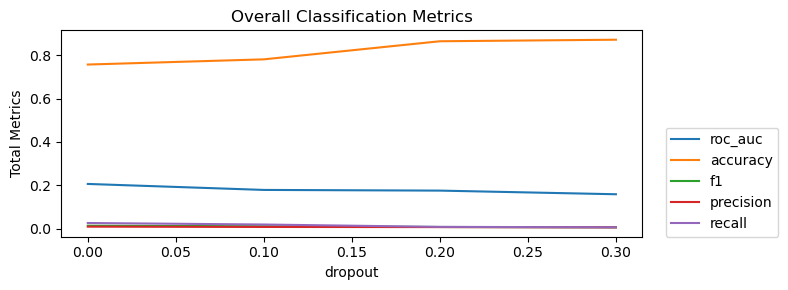

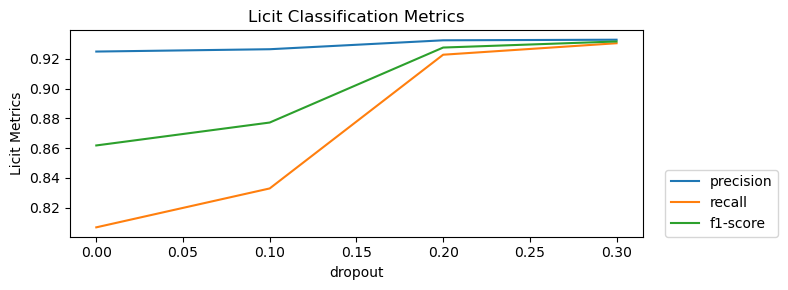

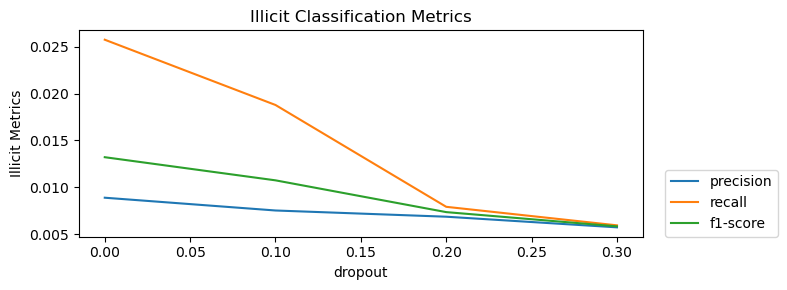

In [ ]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [ ]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [5,10,15,20]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[30374, 93], edge_index=[2, 28954], y=[30374])
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.3, 'weight_decay': 0.0, 'act': <function relu at 0x000001B984151B40>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 10, 'gpu': -1, 'batch_size': 2048, 'num_neigh': 5, 'weight': 0.5, 'verbose': 2, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 244112.0599 |  | Time 14.60
Epoch 0001: Loss 15.0232 |  | Time 14.44
Epoch 0002: Loss 17.2090 |  | Time 14.58
Epoch 0003: Loss 16.6528 |  | Time 14.42
Epoch 0004: Loss 15.2497 |  | Time 14.56
Epoch 0005: Loss 13.8527 |  | Time 15.20
Epoch 0006: Loss 12.4560 |  | Time 15.26
Epoch 0007: Loss 11.3042 |  | Time 15.19
Epoch 0008: Loss 10.0723 |  | Time 15.11
Epoch 0009: Loss 8.9720 |  | Time 15.19
model training complete!
embeddings saved to ./outputs\embeddings_None.npy
labels saved to ./outputs\labels_None.npy
data loaded from loader:
Dat

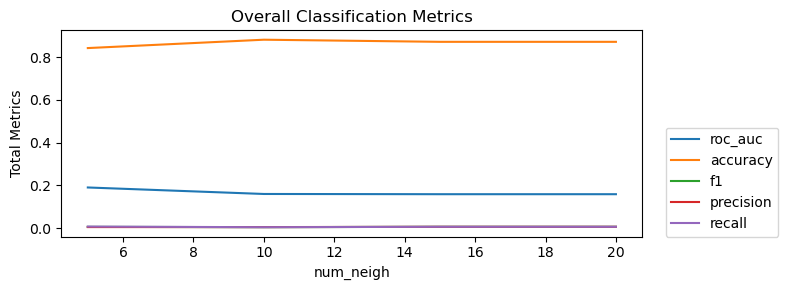

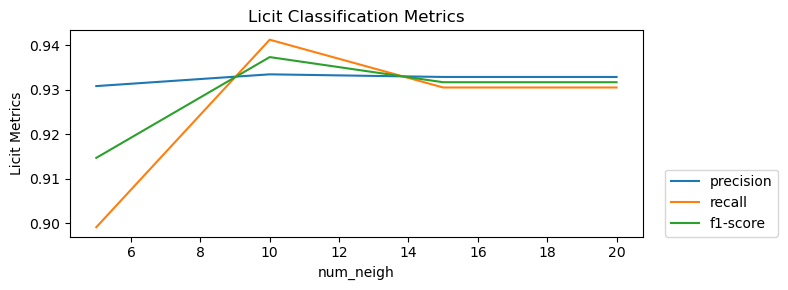

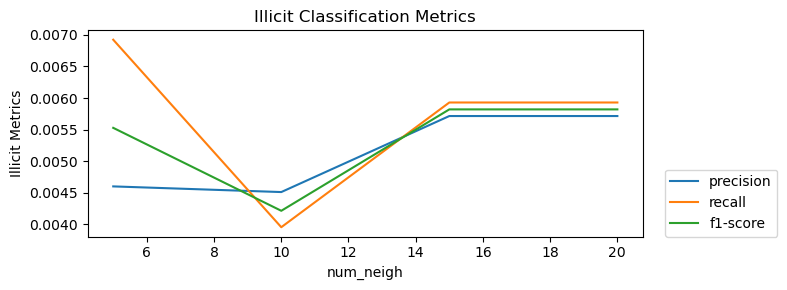

In [ ]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Epochs

In [ ]:
metrics = create_metrics()
para_change = "epoch"
para_list = [10, 20 , 30 , 40, 50]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

data loaded from loader:
Data(x=[30374, 93], edge_index=[2, 28954], y=[30374])
creating model with {'hid_dim': 1024, 'num_layers': 7, 'dropout': 0.3, 'weight_decay': 0.0, 'act': <function relu at 0x000001B984151B40>, 'sigmoid_s': False, 'contamination': 0.1, 'lr': 0.005, 'epoch': 10, 'gpu': -1, 'batch_size': 2048, 'num_neigh': 20, 'weight': 0.5, 'verbose': 2, 'backbone': <class 'torch_geometric.nn.models.basic_gnn.GCN'>}
training model...
Epoch 0000: Loss 191809.7530 |  | Time 16.19
Epoch 0001: Loss 15.4998 |  | Time 16.19
Epoch 0002: Loss 17.6917 |  | Time 16.65
Epoch 0003: Loss 16.8753 |  | Time 16.62
Epoch 0004: Loss 15.4918 |  | Time 16.91
Epoch 0005: Loss 13.9623 |  | Time 16.78
Epoch 0006: Loss 12.4310 |  | Time 16.58
Epoch 0007: Loss 12.7266 |  | Time 16.42
Epoch 0008: Loss 9.9158 |  | Time 16.52
Epoch 0009: Loss 8.8694 |  | Time 16.72
model training complete!
embeddings saved to ./outputs\embeddings_None.npy
labels saved to ./outputs\labels_None.npy
data loaded from loader:
Dat

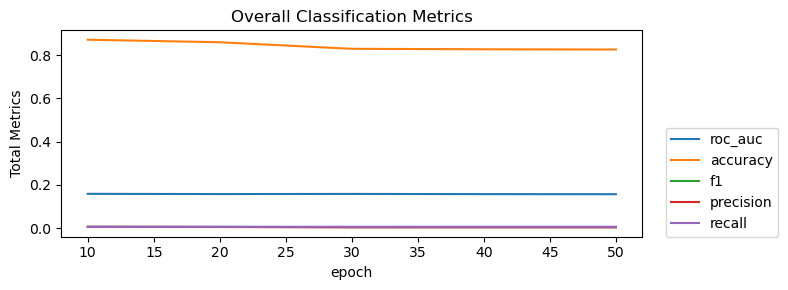

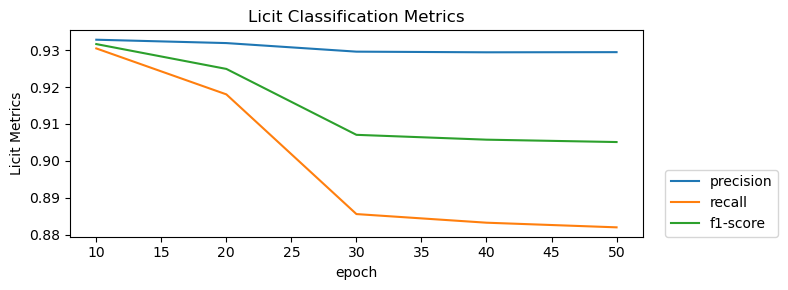

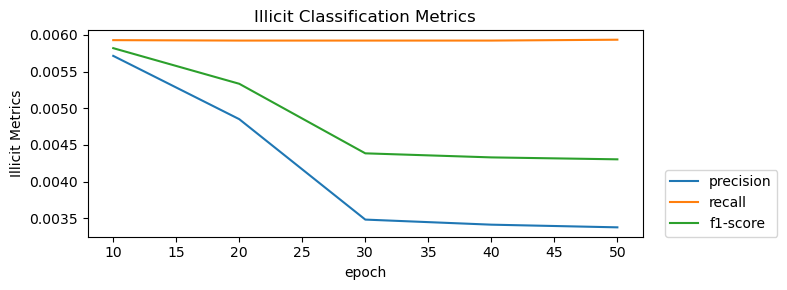

In [ ]:
plot_metrics(metrics, para_list, para_change, x_log=False)